Reproduce Elis' work, for my understanding

It looks like the three relevant bits of code happen in three steps:
- Define the uNet
- straighten the images
- perform segmentation

This notebook does the first of these

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
"""
Resize the images for training

"""
import pathlib
import warnings
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cementum import processing, util

# We don't have the same number of images and masks, unfortunately
# So we'll just open this many
n_imgs = 516
n_total = 516

# Choose some images and masks at random
gen = np.random.default_rng(0)
indices = gen.choice(np.arange(n_total), size=n_imgs, replace=False)

# Split into training and testing here
train_fraction = 0.8
train_indices = gen.choice(indices, size=int(train_fraction * n_imgs), replace=False)
test_indices = np.array([i for i in indices if i not in train_indices])

data_dir = pathlib.Path("data/original cut/")
mask_dir = pathlib.Path("data/masks cut/")

img_paths = np.array(sorted(tuple(data_dir.glob(r"????.tif"))))
mask_paths = np.array(sorted(tuple(pathlib.Path(mask_dir).glob(r"????.tif"))))

img_size = (320, 320)
train_images = [
    processing.resize(Image.open(str(path)), img_size)
    for path in img_paths[train_indices]
]
test_images = [
    processing.resize(Image.open(str(path)), img_size)
    for path in img_paths[test_indices]
]

# Subtract 1 from masks to make them 0-indexed
train_masks = [
    processing.resize(Image.open(str(path)), img_size) - 1
    for path in mask_paths[train_indices]
]
test_masks = [
    processing.resize(Image.open(str(path)), img_size) - 1
    for path in mask_paths[test_indices]
]

# Check that the masks all contain the right values - and contain all of them (which might be unnecessary)
for i, mask in enumerate(train_masks):
    assert (
        np.unique(mask) == [0, 1, 2]
    ).all(), f"{util.bcolours.FAIL}Mask {i} contains vals {util.bcolours.WARNING}{np.unique(mask)}"

assert len(train_images) == len(train_masks), len(train_images)
if len(train_images) + len(test_images) != n_imgs:
    warnings.warn(
        f"{util.bcolours.WARNING}Only {len(train_images) + len(test_images)} images were loaded"
    )

2023-12-08 10:37:36.195343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


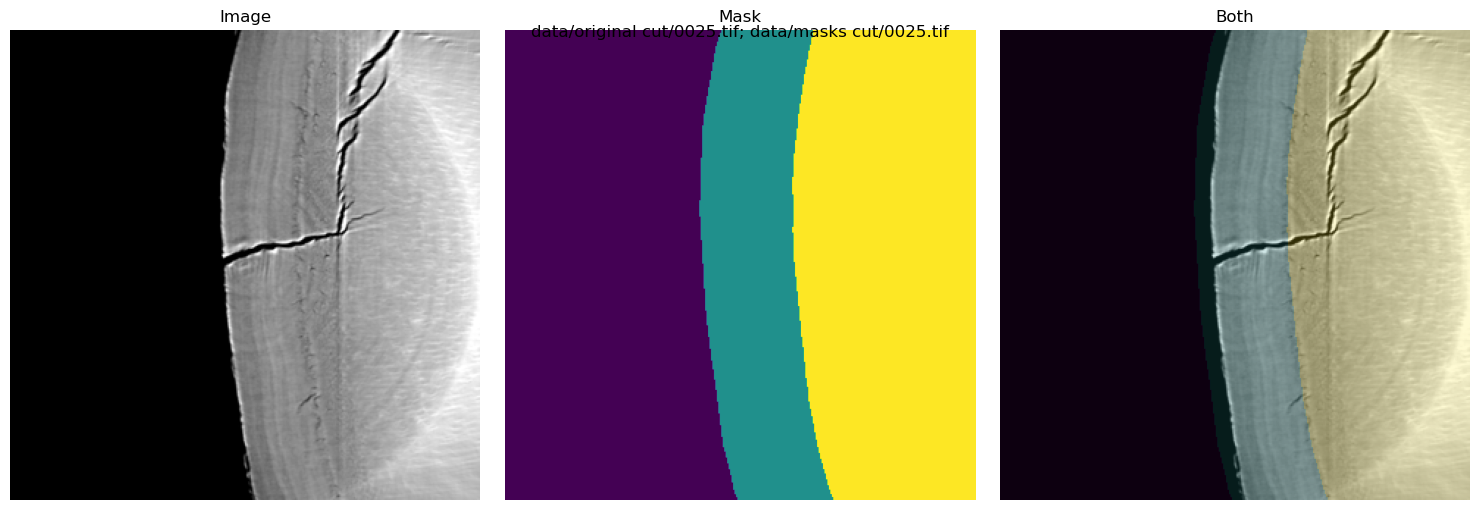

In [4]:
def plot_images(image, mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image, cmap="grey")
    axes[1].imshow(mask)

    axes[2].imshow(image, cmap="gray")
    axes[2].imshow(mask, alpha=0.2)

    for axis, title in zip(axes, ("Image", "Mask", "Both")):
        axis.axis("off")
        axis.set_title(title)

    fig.tight_layout()
    
    return fig


idx = 25
fig = plot_images(train_images[idx], train_masks[idx])
fig.suptitle(f"{img_paths[idx]}; {mask_paths[idx]}")
fig.savefig("before_augmentation.png")

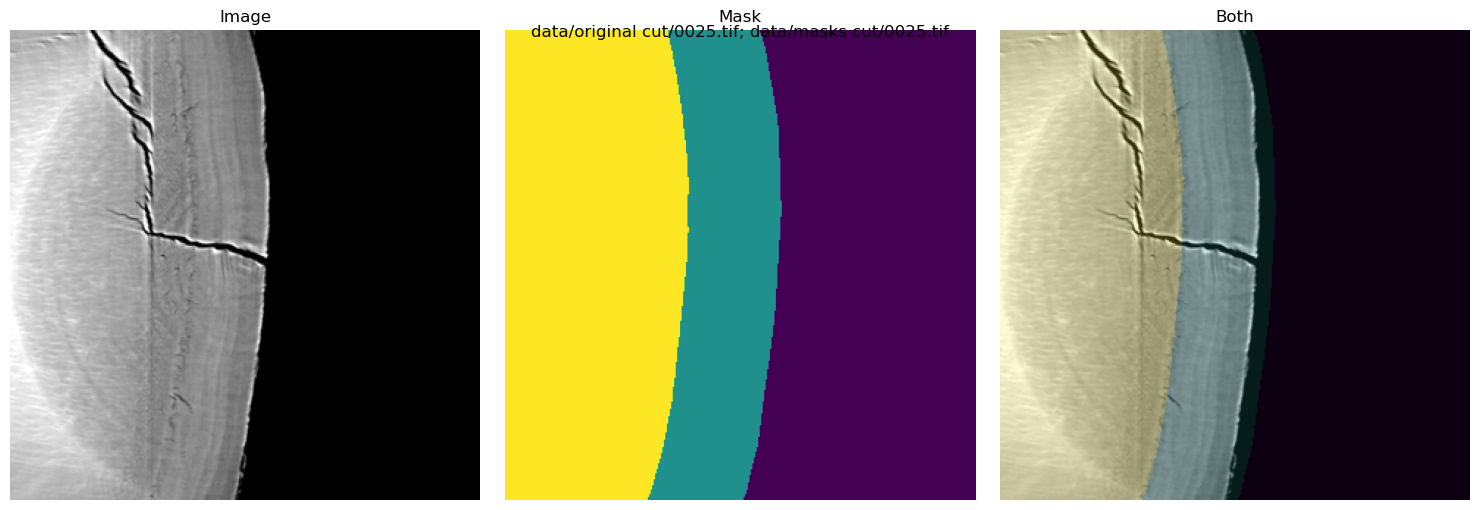

In [5]:
"""
Randomly rotate and flip the images and masks

"""
train_images, train_masks = processing.rotate_and_flip(
    gen, np.array(train_images), np.array(train_masks)
)

fig = plot_images(train_images[idx], train_masks[idx])
fig.suptitle(f"{img_paths[idx]}; {mask_paths[idx]}")
fig.savefig("after_augmentation.png")

In [6]:
"""
Reshape, normalise and split the data
Also find the class weights

"""
from sklearn.utils import class_weight

classes = np.unique(train_masks)
n_classes = len(classes)
assert (
    n_classes == 3
), "We've already checked this, so if this fails then you're in trouble"

# Rescale images to [0, 1] and reshape
X_train = processing.imgs2array(train_images)

# Convert masks to a binary class matrix
y_train = processing.masks2matrix(train_masks, n_classes)

# Find class weights
print(
    f"Class values in the dataset are ... , {dict(zip(*np.unique(train_masks, return_counts=True)))}"
)
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_masks.ravel(),
)

class_weights = dict(zip(range(n_classes), class_weights))
print("Class weights are...:", class_weights)

# Increase class weight for dentine, since the other classes are less important
class_weights[2] *=2
print("Class weights are...:", class_weights)

# Decrease class weight for background, since the other classes are less important
class_weights[0] /= 2
print("Class weights are...:", class_weights)


Class values in the dataset are ... , {0: 15391962, 1: 8434602, 2: 18362236}
Class weights are...: {0: 0.9136543692956969, 1: 1.667290683464772, 2: 0.7658617029719764}
Class weights are...: {0: 0.9136543692956969, 1: 1.667290683464772, 2: 1.5317234059439528}
Class weights are...: {0: 0.45682718464784844, 1: 1.667290683464772, 2: 1.5317234059439528}


In [7]:
"""
Define the uNet

"""
from cementum import unet
from keras.optimizers import Adam
from keras.metrics import Precision, Recall

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = unet.my_unet(
    n_classes=n_classes,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH,
    IMG_CHANNELS=IMG_CHANNELS,
)

model.compile(
    optimizer=Adam(learning_rate=0.002),
    loss="categorical_crossentropy",
    metrics=["accuracy", Precision(), Recall()],
)

In [8]:
"""
Either train or open the model

"""
import os
import pickle
from keras.models import load_model


def model_trained(*files):
    for path in files:
        if not os.path.exists(path):
            return False
    return True


# Probably want a batch_size of 32, 64 or 16
# More epochs will probably be better but might overfit
# Want to shuffle the data since nearby images are very similar
train_kw = {"batch_size": 32, "epochs": 25, "verbose": 1, "shuffle": True}

model_path = "cementum_test.keras"
history_path = "cementum_test.history"
data_path = "cementum_data.pickle"

if model_trained(model_path, history_path, data_path):
    model = load_model(model_path)

    with open(history_path, "rb") as history:
        history = pickle.load(history)

    with open(data_path, "rb") as data:
        X_train, y_train, test_images, test_masks = pickle.load(data)

else:
    with open(data_path, "wb") as f:
        pickle.dump((X_train, y_train, test_images, test_masks), f)
    print("Data cached")

    history = model.fit(
        X_train,
        y_train,
        class_weight=class_weights,
        validation_split=0.2,
        **train_kw,
    )

    model.save(model_path)
    with open(history_path, "wb") as f:
        pickle.dump(history, f)

Data cached
Epoch 1/25
11/11 [==============================] - 61s 5s/step - loss: 0.9206 - accuracy: 0.4506 - precision: 0.6990 - recall: 0.3787 - val_loss: 0.7964 - val_accuracy: 0.4714 - val_precision: 0.7185 - val_recall: 0.4316
Epoch 2/25
11/11 [==============================] - 63s 6s/step - loss: 0.7589 - accuracy: 0.5649 - precision: 0.7358 - recall: 0.4448 - val_loss: 0.7558 - val_accuracy: 0.8153 - val_precision: 0.7335 - val_recall: 0.4510
Epoch 3/25
11/11 [==============================] - 68s 6s/step - loss: 0.6807 - accuracy: 0.8306 - precision: 0.7695 - recall: 0.5079 - val_loss: 0.5635 - val_accuracy: 0.8319 - val_precision: 0.8356 - val_recall: 0.8177
Epoch 4/25
11/11 [==============================] - 69s 6s/step - loss: 0.5481 - accuracy: 0.8542 - precision: 0.8581 - recall: 0.8485 - val_loss: 0.3830 - val_accuracy: 0.8418 - val_precision: 0.8453 - val_recall: 0.8378
Epoch 5/25
11/11 [==============================] - 71s 6s/step - loss: 0.4702 - accuracy: 0.8677 - 

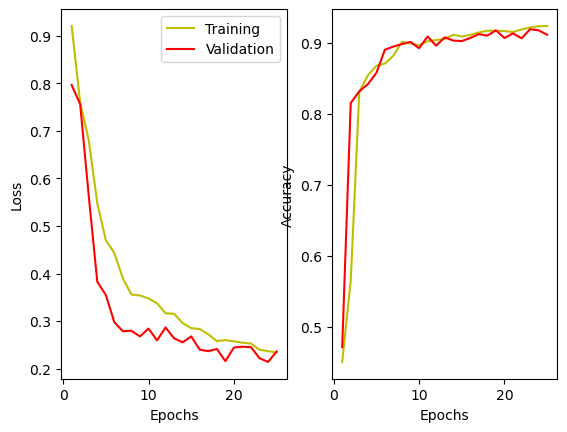

In [9]:
"""
Plot the loss and validation accuracy at each epoch

"""
loss = history.history["loss"]
val_loss = history.history["val_loss"]

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs, loss, "y", label="Training")
axes[0].plot(epochs, val_loss, "r", label="Validation")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, acc, "y", label="Training")
axes[1].plot(epochs, val_acc, "r", label="Validation")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[0].legend()

fig.savefig("training.png")

In [10]:
"""
Calculate intersection over union for each class using the test set

"""
from keras.metrics import MeanIoU

X_test = processing.imgs2array(np.array(test_images))
y_test = processing.masks2matrix(np.array(test_masks), n_classes)

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:, :, :, 0], model.predict(X_test).argmax(axis=3))


def calculate_iou(values, class_idx):
    iou = values[class_idx, class_idx] / (
        values[class_idx, :].sum()
        + values[:, class_idx].sum()
        - values[class_idx, class_idx]
    )
    return iou


values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

for i in range(n_classes):
    class_iou = calculate_iou(values, i)
    print(f"IoU for class {i} is: ", class_iou)

4/4 [==============================] - 4s 806ms/step
IoU for class 0 is:  0.0012670286
IoU for class 1 is:  0.034946367
IoU for class 2 is:  0.0


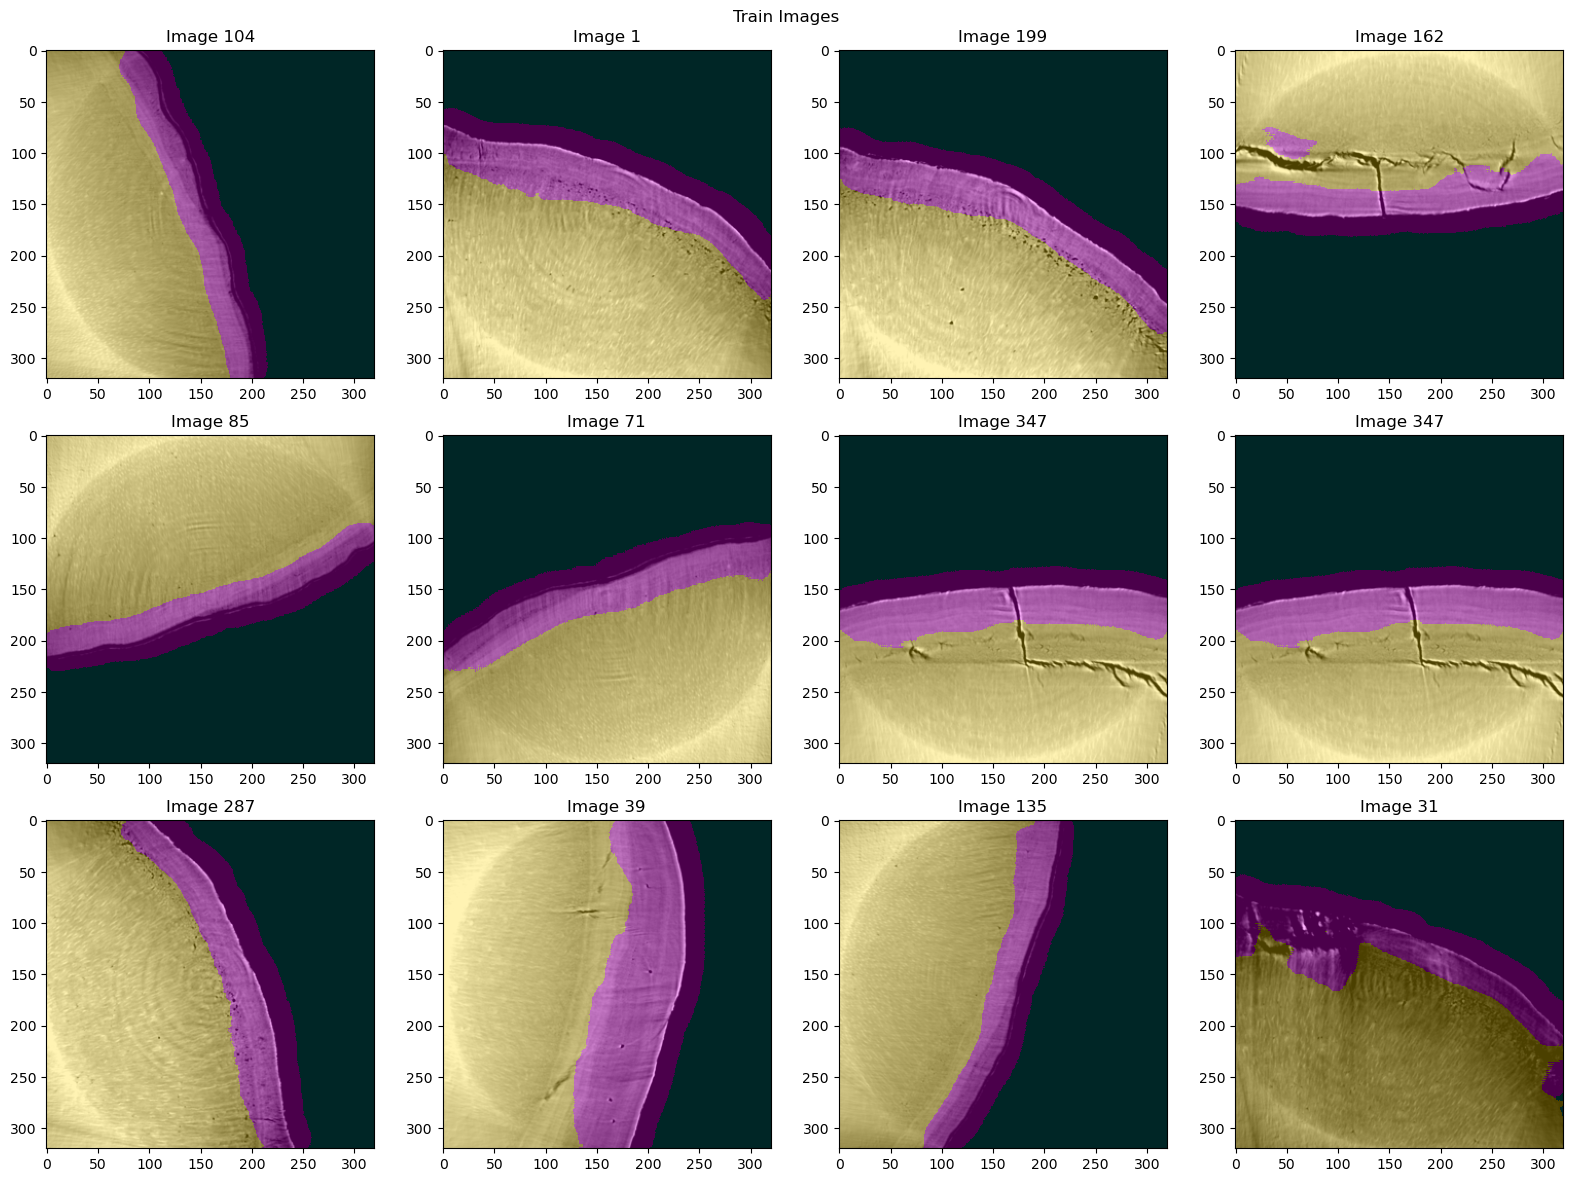

In [11]:
""" Show the prediction for some of the training images """
from matplotlib.colors import ListedColormap


def preprocess_image(image):
    # Add batch axis
    return image[np.newaxis, ...]


# Choose some images and masks at random
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
indices = np.random.randint(0, len(X_train), size=len(axes.ravel()))


def plot_predictions(axes, indices, images):
    cmap = ListedColormap(["teal", "magenta", "gold"])

    for index, axis in zip(indices, axes.ravel()):
        prediction = np.argmax(
            model.predict(preprocess_image(images[index]), verbose=0), axis=-1
        ).squeeze()
        axis.set_title(f"Image {index}")
        axis.imshow(images[index], cmap="gray")
        axis.imshow(prediction, cmap=cmap, alpha=0.3)


plot_predictions(axes, indices, X_train)
fig.suptitle("Train Images")
fig.tight_layout()

fig.savefig("training_predictions.png")

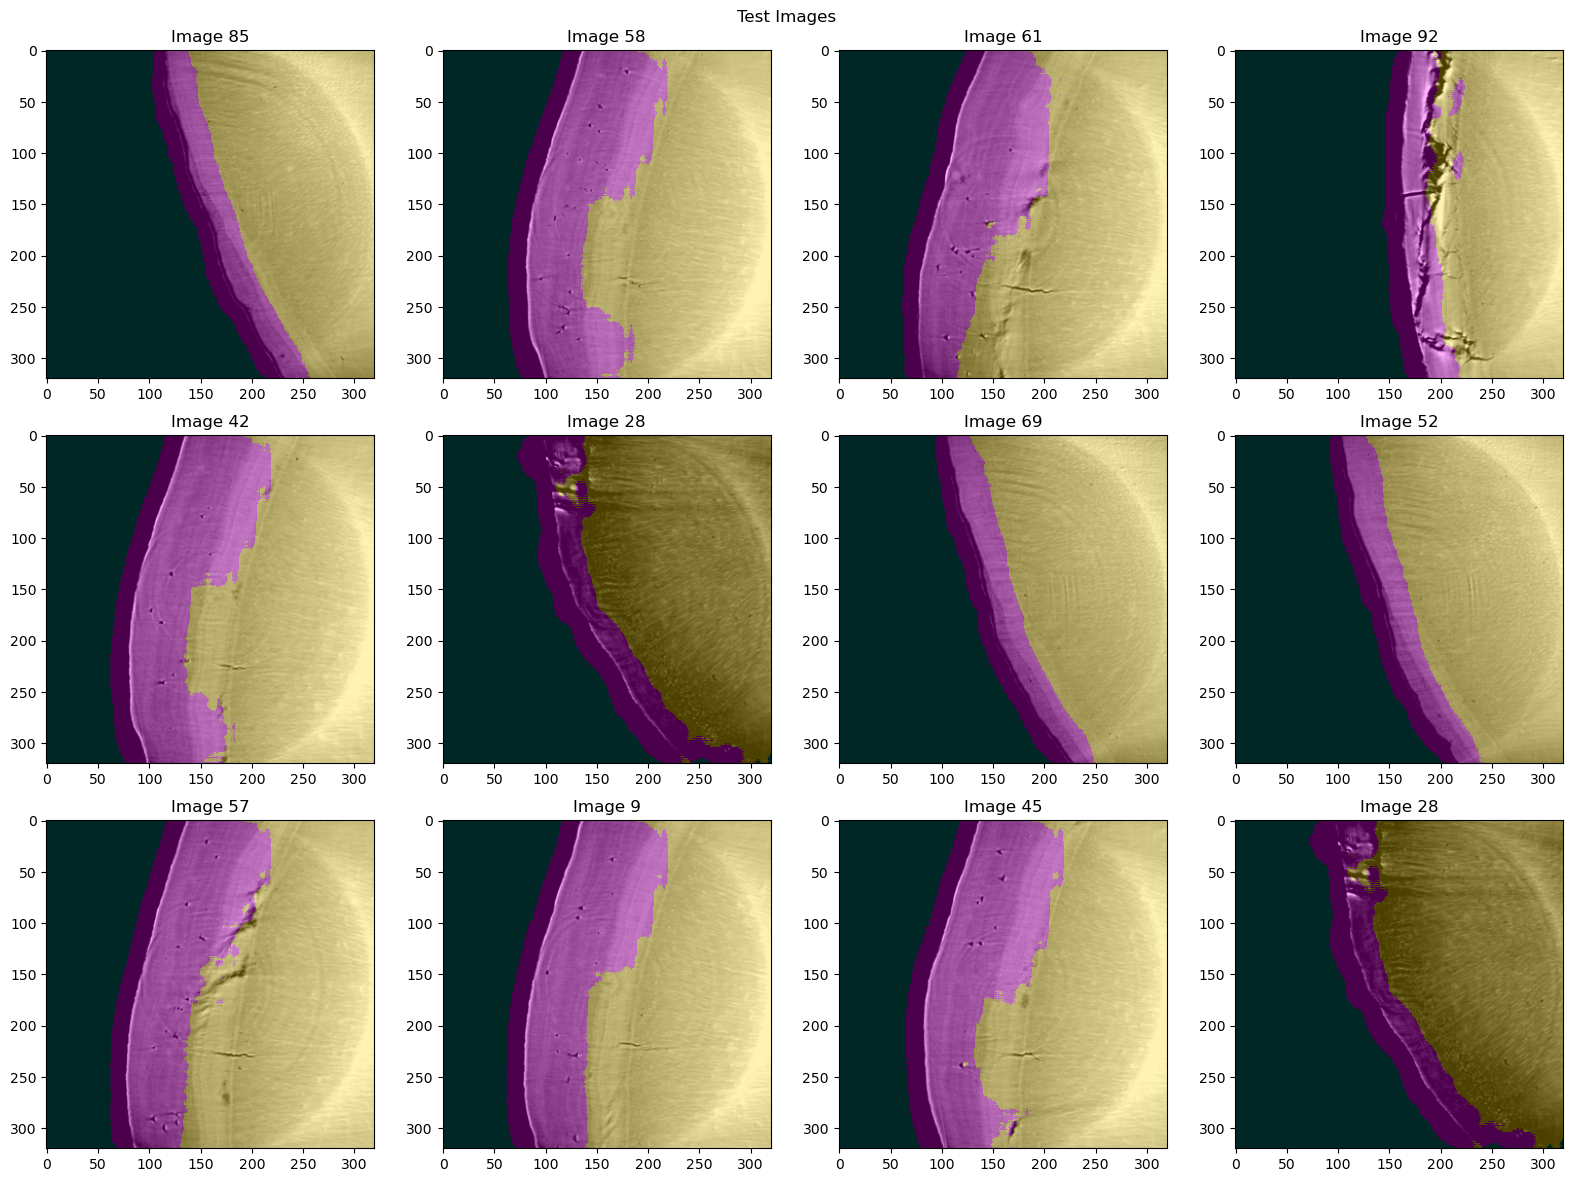

In [12]:
""" Show the prediction for some test images """

# Choose some images at random
indices = np.random.randint(0, len(X_test), size=len(axes.ravel()))

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
plot_predictions(axes, indices, X_test)

fig.suptitle("Test Images")
fig.tight_layout()
fig.savefig("test_predictions.png")

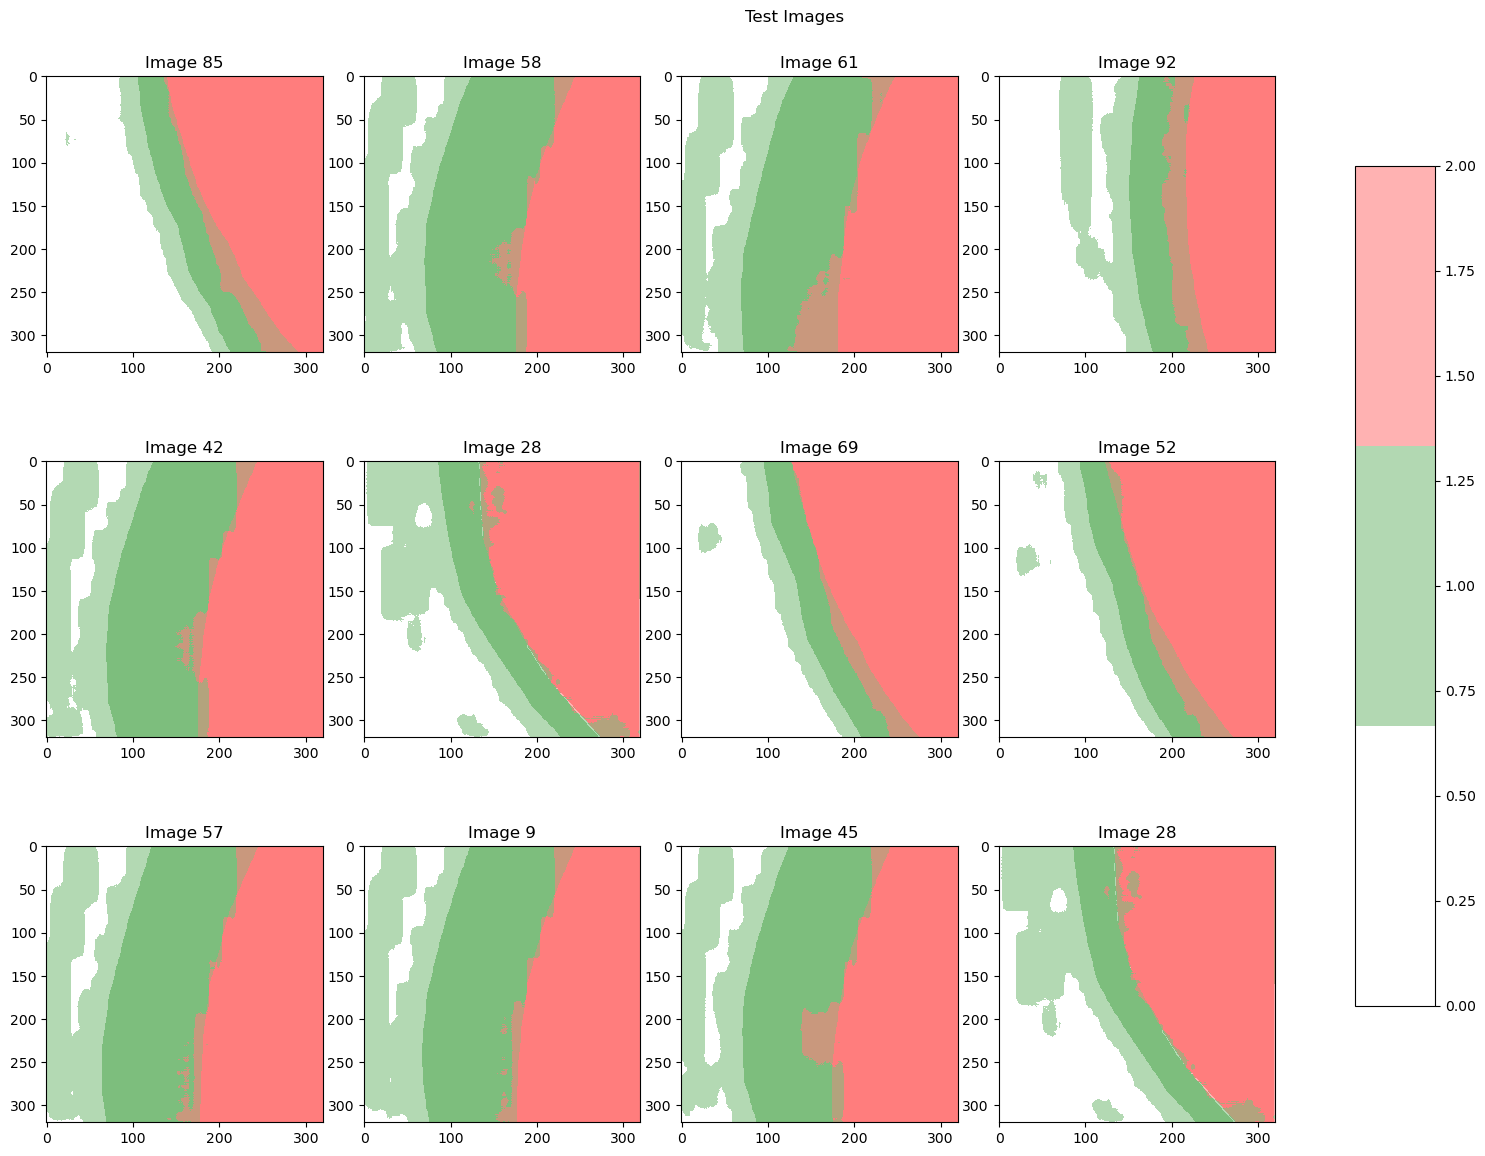

In [13]:
"""
Plot the testing masks and predictions for a single image

"""
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for index, axis in zip(indices, axes.ravel()):
    axis.set_title(f"Image {index}")
    prediction = np.argmax(
        model.predict(preprocess_image(test_images[index]), verbose=0), axis=-1
    ).squeeze()
    axis.imshow(test_masks[index], cmap=ListedColormap(["white", "green", "red"]), alpha=0.3)
    mappable = axis.imshow(prediction, cmap=ListedColormap(["white", "green", "red"]), alpha=0.3)


fig.suptitle("Test Images")
fig.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)